In [266]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [267]:
import cfdnetplus

In [268]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
fields= ['U','p','k','omega', 'nut']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_sep'

In [86]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [269]:
if 'U' in fields:
    l=len(fields)+2
else:
    l=len(fields)

df = np.empty((0,66,256,l))
df_label = np.empty((0,66,256,l))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    df=np.concatenate((df,df_t))
    df_label=np.concatenate((df_label,df_tlabel))
print(df_label.shape)

(2295, 66, 256, 7)


In [270]:
n=3
df_label=df_label[:,:,:,n]
df=df[:,:,:,n]


In [271]:
[a,b,c]=df_label.shape
df=np.reshape(df,[a,b,c,1])
df_label=np.reshape(df_label,[a,b,c,1])
print(df.shape)

(2295, 66, 256, 1)


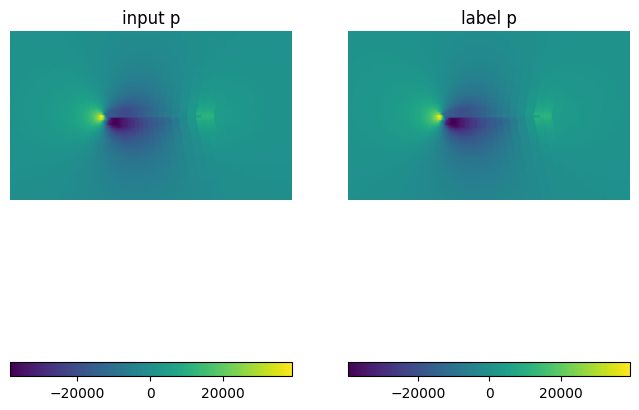

In [273]:

n=1000
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['p']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

In [265]:
#normalise U Vektors


Ux_max=np.max(abs(df[:,:,:,[0]]))
Uy_max=np.max(abs(df[:,:,:,[1]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([Ux_max,Uy_max,0,p_max,k_max,omega_max,nut_max]).reshape(1,1,1,l)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)
print(model_path+'')

[[[[4.41323047e+03 2.61715942e+03 0.00000000e+00 7.33556320e+07
    2.83279031e+05 1.93653164e+04 4.86423264e+01]]]]
cfdnetplus_models/model_sep/


In [274]:
p_max=np.max(abs(df[:,:,:,[0]]))
#normal=[U_max].reshape(1,1,1,1)
normal=p_max

In [131]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



In [275]:
df1=df*1/normal
df_label1=df_label/normal

In [276]:
train_data, test_data, label_train, label_test = train_test_split (df1, df_label1, test_size = 0.15)

20


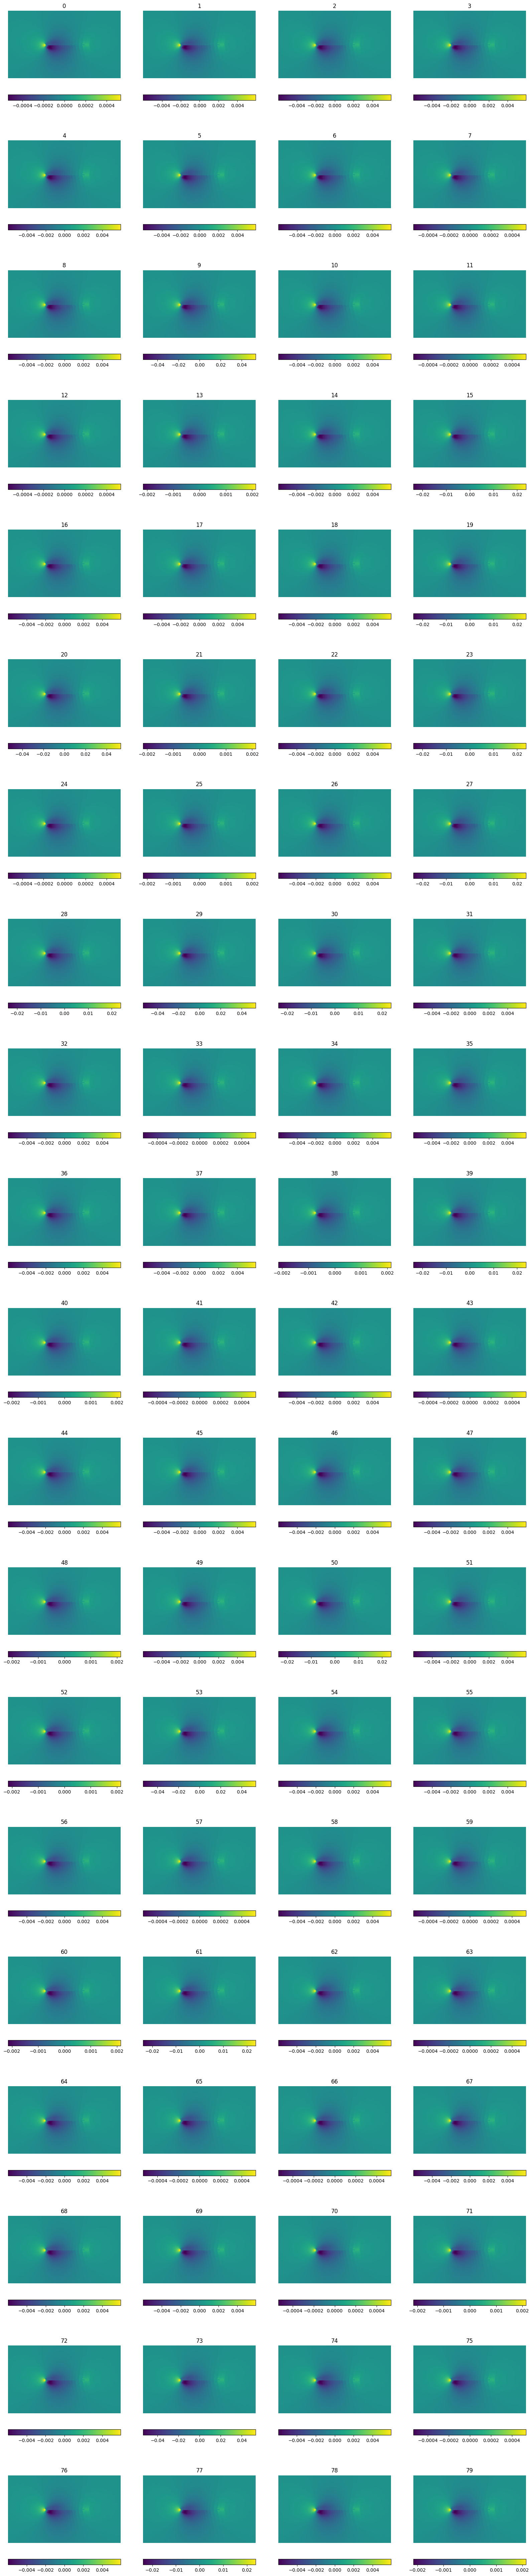

In [277]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [278]:
[a,b,c,d]=df.shape

In [279]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, d)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(d,(4,16),(2,8), activation='linear', padding="same"))

In [280]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 33, 32, 16)        784       
                                                                 
 conv2d_28 (Conv2D)          (None, 11, 8, 64)         36928     
                                                                 
 conv2d_29 (Conv2D)          (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose_27 (Conv2D  (None, 11, 8, 32)        1146912   
 Transpose)                                                      
                                                                 
 conv2d_transpose_28 (Conv2D  (None, 33, 32, 16)       24592     
 Transpose)                                                      
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 66, 256, 1)      

In [281]:
model.compile(optimizer='adam',
              loss='mse')

In [282]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_1', 'training_10', 'training_11', 'training_12', 'training_13', 'training_14', 'training_15', 'training_16', 'training_17', 'training_18', 'training_2', 'training_3', 'training_4', 'training_5', 'training_6', 'training_7', 'training_8', 'training_9']
training_19


In [283]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [284]:
history = model.fit(train_data, label_train, epochs=50, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/50
61/61 [==============================] - ETA: 0s - loss: 1.0460e-05
Epoch 1: loss improved from inf to 0.00001, saving model to training/training_19\vae_best_model_relu.epoch01-loss0.00001.w
61/61 [==============================] - 13s 212ms/step - loss: 1.0460e-05 - val_loss: 1.0687e-05
Epoch 2/50
61/61 [==============================] - ETA: 0s - loss: 1.0402e-05
Epoch 2: loss improved from 0.00001 to 0.00001, saving model to training/training_19\vae_best_model_relu.epoch02-loss0.00001.w
61/61 [==============================] - 13s 209ms/step - loss: 1.0402e-05 - val_loss: 1.0546e-05
Epoch 3/50
61/61 [==============================] - ETA: 0s - loss: 9.8455e-06
Epoch 3: loss improved from 0.00001 to 0.00001, saving model to training/training_19\vae_best_model_relu.epoch03-loss0.00001.w
61/61 [==============================] - 13s 217ms/step - loss: 9.8455e-06 - val_loss: 7.9135e-06
Epoch 4/50
61/61 [==============================] - ETA: 0s - loss: 7.0145e-06
Epoch 4: loss

61/61 [==============================] - 13s 207ms/step - loss: 1.8705e-07 - val_loss: 1.2496e-07
Epoch 31/50
61/61 [==============================] - ETA: 0s - loss: 2.0449e-07
Epoch 31: loss did not improve from 0.00000
61/61 [==============================] - 13s 208ms/step - loss: 2.0449e-07 - val_loss: 1.1092e-07
Epoch 32/50
61/61 [==============================] - ETA: 0s - loss: 1.6158e-07
Epoch 32: loss did not improve from 0.00000
61/61 [==============================] - 13s 207ms/step - loss: 1.6158e-07 - val_loss: 1.6100e-07
Epoch 33/50
61/61 [==============================] - ETA: 0s - loss: 1.4951e-07
Epoch 33: loss improved from 0.00000 to 0.00000, saving model to training/training_19\vae_best_model_relu.epoch33-loss0.00000.w
61/61 [==============================] - 13s 211ms/step - loss: 1.4951e-07 - val_loss: 1.1343e-07
Epoch 34/50
61/61 [==============================] - ETA: 0s - loss: 1.5810e-07
Epoch 34: loss did not improve from 0.00000
61/61 [=====================

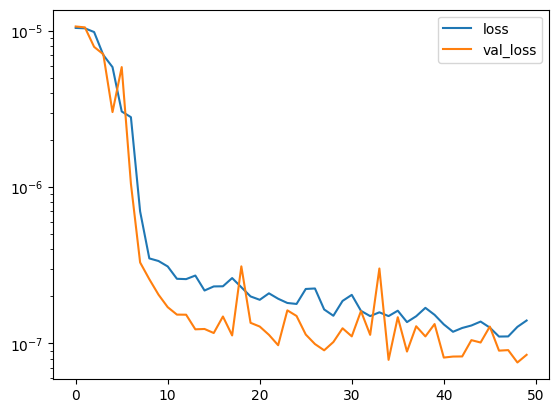

In [285]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [286]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

47
vae_best_model_relu.epoch47-loss0.00000.w


In [287]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_19/vae_best_model_relu.epoch47-loss0.00000.w


In [288]:
test=model.predict(test_data)

11/11 [==============================] - 0s 35ms/step


In [289]:
print(label_test.shape[0])
n=0
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.05327406
min: -0.05394404


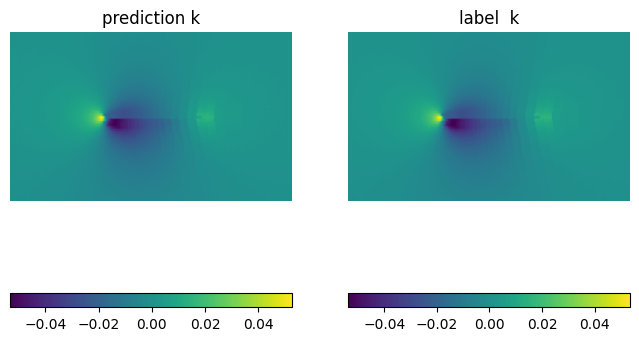

In [296]:
n=40
fig = plt.figure(figsize=(8, 8))
[a,b,c,d]=test.shape
#titles= ['Ux','Uy','Uz','p']
titles= ['k','omega','nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

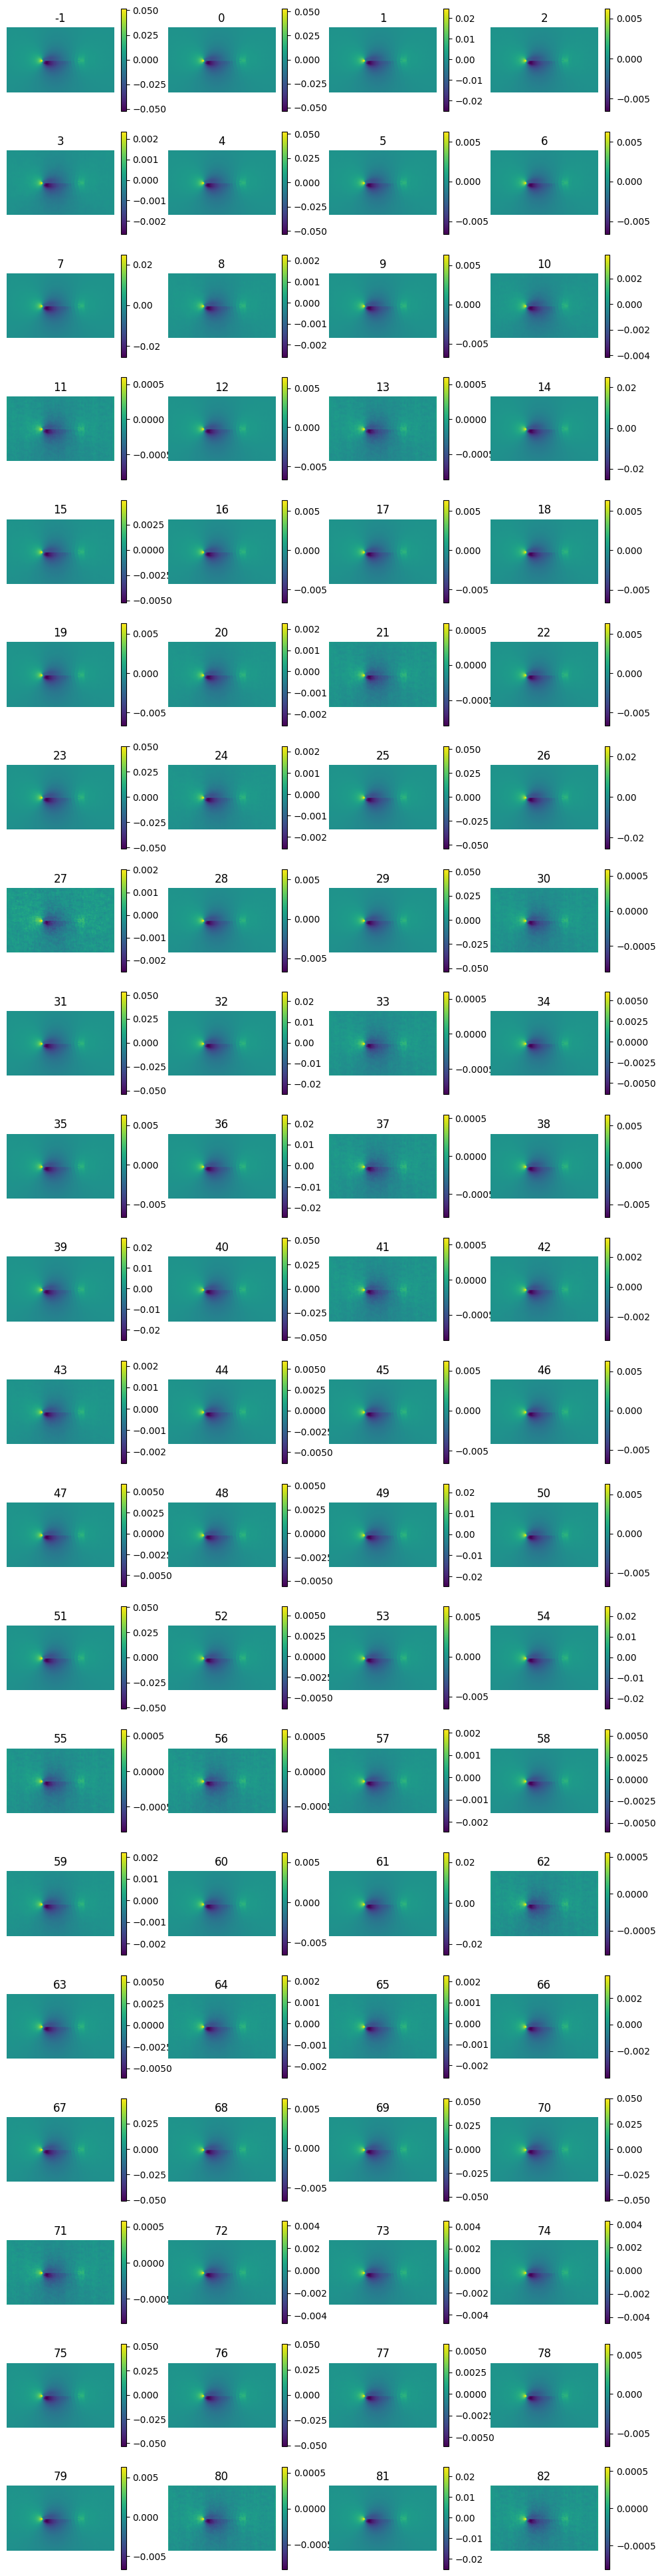

In [291]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()

In [292]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,0],label_test[i,:,:,0]))
    ssim1.append(ssim(test[i,:,:,0],label_test[i,:,:,0]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:1.1173731155289384e-05
0.9999235006928444
8.593970326959307e-08
average ssim: 0.9998308823650125
average mse: 8.986611715850823e-08


In [113]:
print(test.shape)

(345, 66, 256, 2)


In [293]:
#os.mkdir('cfdnetplus_models')
model.save('cfdnetplus_models/model_sep1/model_p')

INFO:tensorflow:Assets written to: cfdnetplus_models/model_sep1/model_p\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model_sep1/model_p\assets
